In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/cs7643

/content/gdrive/My Drive/Colab Notebooks/cs7643


In [3]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 5.5MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=ba364dea4682258e5610ba6fc290bbb8412865ce61ab74aceb36561b1e8eb02a
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.autograd import Variable
import math
import sys
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import utils
from att import MultiheadedAttention
# Auto-reloading of modules in iPython
%load_ext autoreload
%autoreload 2

In [ ]:
# # !pip install music21
# # !pip install pretty_midi
# # !pip install playsound
# # !pip install librosa
# import os
# from pathlib import Path
# from music21 import *
# import pretty_midi
# import glob
# from playsound import playsound
# from scipy.io.wavfile import read, write
# import IPython
# import librosa.display

In [27]:
# CONSTS
random_seed = 11
seq_size = 32
validation_size = 0.15
learning_rate = 1e-3
epchs = 100
num_layers = 2
hidden_size = 256
dropout = 0.2
model_type = 'lstm'
use_cuda = True
print("use_cuda is: %s" % use_cuda)

torch.manual_seed(random_seed)
input_music = 'data/jigs.txt'  # Music

use_cuda is: True


In [6]:
# Read data file
f = open(input_music,"r")
data, buffer = [], ''
store = False
for line in f:
    if 'X' in line:
        buffer += line
    elif line == "\n":
        buffer += line
        data += [buffer]
        buffer = ''
    else:
        buffer += line
f.close()

data = [ song for song in data if len(song) > seq_size + 10 ]
print(data[0])

X: 1
T:A and D
% Nottingham Music Database
S:EF
M:4/4
K:A
M:6/8
P:A
f|"A"ecc c2f|"A"ecc c2f|"A"ecc c2f|"Bm"BcB "E7"B2f|
"A"ecc c2f|"A"ecc c2c/2d/2|"D"efe "E7"dcB| [1"A"Ace a2:|
 [2"A"Ace ag=g||\
K:D
P:B
"D"f2f Fdd|"D"AFA f2e/2f/2|"G"g2g ecd|"Em"efd "A7"cBA|
"D"f^ef dcd|"D"AFA f=ef|"G"gfg "A7"ABc |1"D"d3 d2e:|2"D"d3 d2||




In [7]:
# wd = os.getcwd()
# p = Path()
# song = data[0]
# score = converter.parse(song)
# # score.write('xml', fp=p/'song')
# # score_paths = p.glob('xml/*.xml')
# score = converter.parse(str(wd)+ "/song.xml")
# score.show()

In [8]:
char_idx = ''.join(set(list(open(input_music,'r').read())))
char_list = list(char_idx)

# Split training and validation set
num_train = len(data)
indices = list(range(num_train))
split_idx = int(np.floor(validation_size * num_train))

# Shuffle and split
np.random.seed(random_seed)
np.random.shuffle(indices)
train_idxs, valid_idxs = indices[split_idx:], indices[:split_idx]

train_len, valid_len = len(train_idxs), len(valid_idxs)
print('Number of unique characters: %s' % len(char_idx))
print('Original data length: %s' % len(data))
print('Training data length: %s'% train_len)
print('Validation data length: %s' % valid_len)
assert(train_len + valid_len == len(data)), 'Train_len + valid_len should == len(data)'

Number of unique characters: 87
Original data length: 340
Training data length: 289
Validation data length: 51


In [9]:
def rand_slice(data, slice_len=seq_size):
    data_len = len(data)
    start = random.randint(0, data_len - slice_len)
    end = start + slice_len + 1
    return data[start:end]

def seq_to_tensor(seq):
    out = torch.zeros(len(seq)).long()
    for i, c in enumerate(seq):
        out[i] = char_idx.index(c)
    return out

def song_to_seq_target(song):
    rand_seq = rand_slice(song)
    seq = seq_to_tensor(rand_seq[:-1])
    target = seq_to_tensor(rand_seq[1:])
    assert(len(seq) == len(target)), 'SEQ AND TARGET MISMATCH'
    return seq, target

s, t = song_to_seq_target(data[0])
print(s.size())
assert(t.data[0] == s.data[1])

torch.Size([25])


In [10]:
class AttentionLayer(nn.Module):
    """Implements an Attention Layer"""

    def __init__(self, cuda, nhid):
        super(AttentionLayer, self).__init__()
        self.nhid = nhid
        self.weight_W = nn.Parameter(torch.Tensor(nhid,nhid))
        self.weight_proj = nn.Parameter(torch.Tensor(nhid, 1))
        self.softmax = nn.Softmax()
        self.weight_W.data.uniform_(-0.1, 0.1)
        self.weight_proj.data.uniform_(-0.1,0.1)
        self.cuda = cuda

    def forward(self, inputs, attention_width=3):
        results = None
        for i in range(inputs.size(0)):
            if(i<attention_width):
                output = inputs[i]
                output = output.unsqueeze(0)

            else:
                lb = i - attention_width
                if(lb<0):
                    lb = 0
                selector = torch.from_numpy(np.array(np.arange(lb, i)))
                if self.cuda:
                    selector = Variable(selector).cuda()
                else:
                    selector = Variable(selector)
                vec = torch.index_select(inputs, 0, selector)
                u = batch_matmul(vec, self.weight_W, nonlinearity='tanh')
                a = batch_matmul(u, self.weight_proj)
                a = self.softmax(a)
                output = None
                for i in range(vec.size(0)):
                    h_i = vec[i]
                    a_i = a[i].unsqueeze(1).expand_as(h_i)
                    h_i = a_i * h_i
                    h_i = h_i.unsqueeze(0)
                    if(output is None):
                        output = h_i
                    else:
                        output = torch.cat((output,h_i),0)
                output = torch.sum(output,0)
                output = output.unsqueeze(0)

            if(results is None):
                results = output

            else:
                results = torch.cat((results,output),0)

        return results

In [11]:
class RelativeGlobalAttention(torch.nn.Module):
    def __init__(self, h=8, d=256, add_emb=False, max_seq=2048, **kwargs):
        super().__init__()
        self.len_k = None
        self.max_seq = max_seq
        self.E = None
        self.h = h
        self.d = d
        self.dh = d // h
        self.Wq = torch.nn.Linear(self.d, self.d)
        self.Wk = torch.nn.Linear(self.d, self.d)
        self.Wv = torch.nn.Linear(self.d, self.d)
        self.fc = torch.nn.Linear(d, d)
        self.additional = add_emb
        self.E = torch.randn([self.max_seq, int(self.dh)], requires_grad=False)
        if self.additional:
            self.Radd = None

    def forward(self, inputs, mask=None, **kwargs):
        """
        :param inputs: a list of tensors. i.e) [Q, K, V]
        :param mask: mask tensor
        :param kwargs:
        :return: final tensor ( output of attention )
        """
        q = inputs[0]
        q = self.Wq(q)
        q = torch.reshape(q, (q.size(0), q.size(1), self.h, -1))
        q = q.permute(0, 2, 1, 3)  # batch, h, seq, dh

        k = inputs[1]
        k = self.Wk(k)
        k = torch.reshape(k, (k.size(0), k.size(1), self.h, -1))
        k = k.permute(0, 2, 1, 3)

        v = inputs[2]
        v = self.Wv(v)
        v = torch.reshape(v, (v.size(0), v.size(1), self.h, -1))
        v = v.permute(0, 2, 1, 3)

        self.len_k = k.size(2)
        self.len_q = q.size(2)

        E = self._get_left_embedding(self.len_q, self.len_k).to(q.device)
        QE = torch.einsum('bhld,md->bhlm', [q, E])
        QE = self._qe_masking(QE)
        Srel = self._skewing(QE)

        Kt = k.permute(0, 1, 3, 2)
        QKt = torch.matmul(q, Kt)
        logits = QKt + Srel
        logits = logits / math.sqrt(self.dh)

        if mask is not None:
            logits += (mask.to(torch.int64) * -1e9).to(logits.dtype)

        attention_weights = F.softmax(logits, -1)
        attention = torch.matmul(attention_weights, v)

        out = attention.permute(0, 2, 1, 3)
        out = torch.reshape(out, (out.size(0), -1, self.d))

        out = self.fc(out)
        return out, attention_weights

    def _get_left_embedding(self, len_q, len_k):
        starting_point = max(0,self.max_seq-len_q)
        e = self.E[starting_point:,:]
        return e

    def _skewing(self, tensor: torch.Tensor):
        padded = F.pad(tensor, [1, 0, 0, 0, 0, 0, 0, 0])
        reshaped = torch.reshape(padded, shape=[padded.size(0), padded.size(1), padded.size(-1), padded.size(-2)])
        Srel = reshaped[:, :, 1:, :]
        if self.len_k > self.len_q:
            Srel = F.pad(Srel, [0, 0, 0, 0, 0, 0, 0, self.len_k-self.len_q])
        elif self.len_k < self.len_q:
            Srel = Srel[:, :, :, :self.len_k]

        return Srel

    @staticmethod
    def _qe_masking(qe):
        mask = utils.sequence_mask(
            torch.arange(qe.size()[-1] - 1, qe.size()[-1] - qe.size()[-2] - 1, -1).to(qe.device),
            qe.size()[-1])
        mask = ~mask.to(mask.device)
        return mask.to(qe.dtype) * qe

In [18]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model='gru', num_layers=1):
        super(MusicRNN, self).__init__()
        self.model = model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.attentionlayer = RelativeGlobalAttention()
        self.embeddings = nn.Embedding(input_size, hidden_size)
        if self.model == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers)
        elif self.model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers)
        else:
            raise NotImplementedError
            
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.drop = nn.Dropout(p=dropout)
        
    def init_hidden(self):
        if self.model == 'lstm':
            self.hidden = (torch.zeros(self.num_layers, 1, self.hidden_size),
                           torch.zeros(self.num_layers, 1, self.hidden_size))
        elif self.model == 'gru':
            self.hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        
    def forward(self, seq):
        embeds = self.embeddings(seq.view(1, -1))
        rnn_out, self.hidden = self.rnn(embeds.view(1,1,-1), self.hidden)
        rnn_out,_ = self.attentionlayer.forward([rnn_out,rnn_out,rnn_out],None)
        rnn_out = self.drop(rnn_out)
        output = self.out(rnn_out.view(1,-1))
        return output

In [13]:
def calculate_loss(seq, target, fit=True):
    model.init_hidden() 
    model.zero_grad()   
    loss = 0
    
    for i, c in enumerate(seq):
        output = model(c)
#         print(output.shape)
#         print(target[i])
        loss += loss_function(output, target[i].unsqueeze(0))
        
    if fit:
        loss.backward()
        optimizer.step()
    
    return loss.item() / len(seq)

In [22]:
# Model
in_size, out_size = len(char_idx), len(char_idx)
model = MusicRNN(in_size, hidden_size, out_size, model_type, num_layers)
t_loss, v_loss = 0, 0
t_losses, v_losses = [], []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

In [28]:
# Train
for epoch in range(epchs):
    # Training
    for i, song_idx in enumerate(train_idxs):
        loss = calculate_loss(*song_to_seq_target(data[song_idx]))
        t_loss += loss
        
        msg = '\rTraining Epoch: {}, {:.2f}% iter: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(train_idxs)*100, i, loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    t_losses.append(t_loss / len(train_idxs))
        
    # Validation
    for i, song_idx in enumerate(valid_idxs):
        loss = calculate_loss(*song_to_seq_target(data[song_idx]), fit=False)
        v_loss += loss
        
        msg = '\rValidation Epoch: {}, {:.2f}% iter: {} Loss: {:.4}'.format(
             epoch, (i+1)/len(valid_idxs)*100, i, loss)
        sys.stdout.write(msg)
        sys.stdout.flush()
    print()
    v_losses.append(v_loss / len(valid_idxs))
    
    t_loss, v_loss = 0, 0

Training Epoch: 0, 100.00% iter: 288 Loss: 1.288
Validation Epoch: 0, 100.00% iter: 50 Loss: 1.092
Training Epoch: 1, 100.00% iter: 288 Loss: 1.369
Validation Epoch: 1, 100.00% iter: 50 Loss: 1.367
Training Epoch: 2, 100.00% iter: 288 Loss: 1.2
Validation Epoch: 2, 100.00% iter: 50 Loss: 2.099
Training Epoch: 3, 100.00% iter: 288 Loss: 1.381
Validation Epoch: 3, 100.00% iter: 50 Loss: 1.514
Training Epoch: 4, 100.00% iter: 288 Loss: 1.312
Validation Epoch: 4, 100.00% iter: 50 Loss: 1.373
Training Epoch: 5, 100.00% iter: 288 Loss: 1.411
Validation Epoch: 5, 100.00% iter: 50 Loss: 1.365
Training Epoch: 6, 100.00% iter: 288 Loss: 1.386
Validation Epoch: 6, 100.00% iter: 50 Loss: 0.9656
Training Epoch: 7, 100.00% iter: 288 Loss: 1.419
Validation Epoch: 7, 100.00% iter: 50 Loss: 0.1792
Training Epoch: 8, 100.00% iter: 288 Loss: 1.419
Validation Epoch: 8, 100.00% iter: 50 Loss: 0.4953
Training Epoch: 9, 100.00% iter: 288 Loss: 1.05
Validation Epoch: 9, 100.00% iter: 50 Loss: 0.9562
Training 

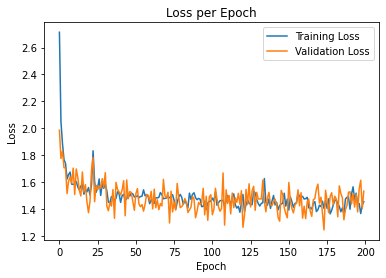

In [29]:
plt.plot(t_losses, label='Training Loss')
plt.plot(v_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [ ]:
def write_song(prime_str='X', max_len=1000, temp=0.8):
    model.init_hidden()
    
    output = 'X'
    prime = seq_to_tensor(output)
    for i in range(len(prime)-1):
        _ = model(prime[i])

    for j in range(max_len):
        out = model(seq_to_tensor(output[-1])).data.view(-1)
        
        out = np.array(np.exp(out/temp))
        dist = out / np.sum(out)
      
        output += char_idx[np.random.choice(len(dist), p=dist)]
        if output[-3:] == '/n':
            break

    return output

In [ ]:
sample_song = write_song(max_len=1000, temp=0.8)
print(sample_song)
with open("sample_song.txt", "w") as text_file:
    print(sample_song, file=text_file)

X: 95
T:Hump The Hurver
% Nottingham Music Database
S:Trad, arr Phil Rowe
M:6/8
K:G
M:6/8
|d/2c/2 "D"dcd|"G"Bec "A7"ede|
"D"fdd "A7"d2A|
"D"d2A F2A|"E"B2e "A7"ABc|"D"d2A "A7"A2g|"D"fdd d2:|
P:B
f/2g/2|"D"a2A A2A|"E7"BAB "A"A3|"A"A3|
P:C
|^A/2B/2|"A"c2c cBA|"Em"e2d "A"B2c|"D"d3/2c/2 "D"dcd|"A7"efA A2c|"G"B2c d2d|"Am"e2e c3|"A7"e3 d2c|"D7"d3 A3|"G"d3 -d2::
b|"D"a2f "A7"d2c|-Bc ABc|"D"d2A d2f|"A"g2e c2e|"D"d3 "A"A2A|"D"def "A7"gec|"D"dcd "A7"^gec|"D"dcd "A7"ede|
"D"fdf afa|"A"a3 agf|"E7"edB "A"A3|"A"Ace acf|"A"e2c A3:|
P:B
A/2G/2|"A"Ace a2f|"A"aee c2A|
"Em"B3 -B2c|"D"dcd "A"e2e|"A"A3/2B/2c "A"A3|"A"A3/2B/2A|
"D"A2a a2d|"E"geg "D"a2f|"A"e2c ABc|"D"ded dAF|"G"G2B "D"A2A|"Em"e2e "A7"e2d|"D"ABA f2d|"A"e2e "D"f2a|"Em"agf "A7"gec|"D"d3 -d2:|
P:B
f/2g/2|
"D"afd d2f|"D"d3 d2:|
P:B
d/2c/2|"G"B2B "D"A2d|"Em"cde "A"d2B|"A"A3 A3| "E7"e2e e2^f|
"D"d2A ABA|"Em"G3 G2:|
P:B
D|"G"G2G "D"D3:|

"Em"e2e e^def|"Em"g2g3 e2f|b3 Q2B|"D"A3 FAc|"Am"ABc "D7"A2c|"G"B2G "C7"E2G|
"F#m"ABc "E"dcd|"E"B2B "A"A2]"E7"e3|"A